In [6]:
%run dihiggs_dataset.ipynb

import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F   # NOTE: I don't think this is used
import torch.autograd as autograd
import torch

from IPython import display
from matplotlib import pyplot as plt

#
print(torch.cuda.is_available())

True


In [7]:
os.makedirs("images", exist_ok=True)

#parser = argparse.ArgumentParser()

"""
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
"""
#opt = parser.parse_args()
#print(opt)
class opt():   # Class used for optimizers in the future. Defines all variables and stuff needed.
    n_epochs = 20000   # an epoch is the number of times it works through the entire training set
    #batch_size = 1000   # the training set is broken up into batches, 
                        # and the average loss is used from a given batch for back propagation
    lr = 0.001   # learning rate (how much to change based on error)
    b1 = 0.9     # Used for Adam. Exponential decay rate for the first moment. 
    b2 = 0.999   # Used for Adam. Exponential decay rate for the second moment estimates (gradient squared)
    #NOTE: The default epsilon for torch.optim.adam is 1e-8, so I will just leave it that way
    
    #n_cpu = 2   # not used rn
    latent_dim = 100 #size of noise input to generator (latent space) 
    #img_size = 28
    # channels = 1   # Only used for img_shape right below, and img_shape isn't needed
    n_critic = 5   # The generator is trained after this many critic steps
    #   clip_value = 0.01   # No other usages rn. 
    sample_interval = 400   # Determines when a to save the image(s?) generated

# img_shape = (opt.channels, opt.img_size, opt.img_size)   # Not used rn

cuda = True if torch.cuda.is_available() else False




class Generator(nn.Module):
    """
    Create hidden layers. Apply normalization. Apply leaky relu. 
    """
    def __init__(self):
        super(Generator, self).__init__()   

        def block(in_feat, out_feat, normalize=True):   # This function creates the hidden layers
            layers = [nn.Linear(in_feat, out_feat)]   # layer is a hidden layer. Takes input
                                                      # (batch_size,in_feat) and give an output (batch_size,out_feat)
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))   # adds normalization to what Layers does to input and comes out in
                                                               # size (batch_size,out_feat). I think this does bn1d(linear(input))
            layers.append(nn.LeakyReLU(0.2, inplace=True))   # inplace means just modify input, don't allocate more memory
            return layers



        """
        stores layers and functions applied to layers
        """       
        self.model = nn.Sequential(   
            *block(opt.latent_dim, 128, normalize=False),   # first layer
            *block(128, 256),   # second layer
            *block(256, 512),   # 3rd layer
            *block(512, 1024),   # 4th layer
            nn.Linear(1024, 784),   # final layer. Output is size 25
            nn.Tanh()   # Using tanh for final output (why tanh vs leaky relu?)
        )

    def forward(self, z):
        """
        applies layers to input to get img
        """
        img = self.model(z)   # applies model (layers and functions on layers) to z
        #img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    """
    Discriminator/critic layers
    """
    def __init__(self):
        super(Discriminator, self).__init__()   # Just uses the module constructor with name Discriminator 

        self.model = nn.Sequential(
            nn.Linear(784, 512),   # first layer
            nn.LeakyReLU(0.2, inplace=True),   # apply leaky relu to layer
            nn.Linear(512, 256),   # 2nd layer
            nn.LeakyReLU(0.2, inplace=True),   # apply leaky relu to layer
            nn.Linear(256, 1),   # Final layer to give output. Output is size 1 (validity score)
                                 # NOTE: weird to end with comma
        )

    def forward(self, img):
        """
        applies model to image and gives validity score
        """
        img_flat = img.view(img.shape[0], -1)   # TODO: Figure out what this does 
        validity = self.model(img_flat)   # calculates validity score
        return validity


# ******* OUT OF CLASSES NOW ************


# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    
    
training_dataset = datasets.MNIST("", train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
testing_dataset = datasets.MNIST("", train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))
# testing_dataset -> out-of-sample testing data to run through nn.If you run in sample data only, won't be able to tell
# whether The nn has overfitted
train_set = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle = True)
test_set = torch.utils.data.DataLoader(testing_dataset, batch_size=10, shuffle = True) 

## Configure data loader - CHANGE
#os.makedirs("./data/", exist_ok=True)
#dataloader = torch.utils.data.DataLoader(
 #   DiHiggsSignalMCDataset('./DiHiggs Data', generator_level = False),
  #  batch_size=opt.batch_size,
  #  shuffle=True,
#)
print('done')

done


In [9]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# def mnist_data():
#     compose = transforms.Compose(
#         [transforms.ToTensor(),
#          transforms.Normalize((.5,), (.5,))
#         ])
#     out_dir = '{}/dataset'.format(DATA_FOLDER)
#     return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [10]:
def compute_gradient_penalty(D, real_samples, fake_samples):   # TODO: Find out why these are .data
    """
    Calculates the gradient penalty loss for WGAN GP
    D input will be discrimantor function
    real_samples and fake_samples are from reality and generator. Both are sent in via memory location of buffer
    
    """
    # Random weight term for interpolation between real and fake samples (how much of each)
    alpha = Tensor(np.random.random((real_samples.size(0),1)))   # This is a tensor designating which to use where

  #  print(alpha.shape)
    # Get random interpolation between real and fake samples
   # print(real_samples.shape)
    
    # Gets some of real and some of fake samples for gradient penalty calculation
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    # .requires grad is something attached to all tensors and can be used to speed up (by making false I think)
    # It is automatically false, but if you need gradient then set to be true
    # TODO: Understand how this statement works

   # print(interpolates.shape)

    d_interpolates = D(interpolates)   # Run discriminator on interpolates to get validity scores
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)   
    
    # Get gradient w.r.t. interpolates (uses inputs and outputs to calculate )
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,   # TODO: figure out what this is for
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)   # still need to figure out view thing
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()   # Normalize and then average gradients for penalty
    return gradient_penalty


In [11]:
DATA_FOLDER = './torch_data/VGAN/MNIST'

In [12]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
train_set = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(train_set)


num_test_samples = 16
test_noise = noise(num_test_samples)


2.3037574


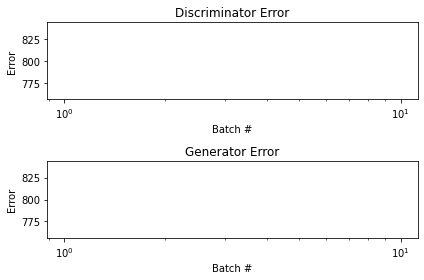

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
[Epoch 1/20000] [Batch 210/600] [D loss: -6.163323] [G loss: 3.483780]
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
[Epoch 1/20000] [Batch 220/600] [D loss: -5.735228] [G loss: 5.903938]
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
[Epoch 1/20000] [Batch 230/600] [D loss: -6.450203] [G loss: 5.914916]
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<clas

In [ ]:
# Optimizers (Adam optimizers are an alternative to stochastic gradient descent. TODO learn more about them)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))   
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

dis_error = []
gen_error = []

# ----------
#  Training
# ----------

batches_done = 0   # Counter for batches
for epoch in range(opt.n_epochs):   # Loop through all epochs
    for i, (x,_) in enumerate(train_set): # x is in dataloader (a batch I think). i
                                       # is the index of x (number of times critic is trained this epoch)
        #if cuda:
         #   x = x.cuda()

        # Configure input
        #x = np.ndarray(x)
        print(type(x))
        real_imgs = Variable(images_to_vectors(x.cuda())) #
        #print(real_imgs)
        #real_imgs = Variable(images_to_vectors(x).type(Tensor))   # Variable is a wrapper for the Tensor x was just made into

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()   # Make gradients zero so they don't accumulate

        # Sample noise (latent space) to make generator input
        z = Variable(Tensor(np.random.normal(0, 1, (x.shape[0], opt.latent_dim))).cuda())   # Once again Variable wraps the Tensor

        # Generate a batch of images from the latent space sampled
        fake_imgs = generator(z)
        #fake_imgs = generator(noise(x.size(0)))
        #print(fake_imgs[0])

        # Calculate validity score for real images
        real_validity = discriminator(real_imgs)

        # Calculate validity score for fake images
        fake_validity = discriminator(fake_imgs)

        # Calculate gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # TODO: figure out why .data is used

        # Calculate loss for critic (Adversarial loss)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()   # Do back propagation 
        optimizer_D.step()   # Update parameters based on gradients for individuals

        optimizer_G.zero_grad()   # Resets gradients for generator to be zero to avoid accumulation

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()


            # ----------------------------
            # Save stuff when time is right
            # ----------------------------
            if batches_done % 10 == 0:
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch, opt.n_epochs, i, len(train_set), d_loss.item(), g_loss.item())
                )

            if batches_done % opt.sample_interval == 0:
                save_image(fake_imgs.data[:728], "images/%d.png" % batches_done, nrow=5, normalize=True)
                # Display stuff
                display.clear_output(True)

                dis_error.append(d_loss.item())
                gen_error.append(g_loss.item())
                print(g_loss.data.cpu().numpy())
                # Display Images
                test_images = vectors_to_images(generator(test_noise)).data.cpu()
                # Display status Logs

                # Model Checkpoints
                fig, axs = plt.subplots(2)
                axs[0].plot(batches_done)
                axs[1].plot(batches_done)
                axs[0].set_title("Discriminator Error")
                axs[0].set_xlabel("Batch #")
                axs[0].set_ylabel("Error")
                axs[0].set_xscale('log')
                axs[1].set_title("Generator Error")
                axs[1].set_xlabel("Batch #")
                axs[1].set_ylabel("Error")
                axs[1].set_xscale('log')
                fig.tight_layout()
                plt.show()

            batches_done += opt.n_critic
            

            
            
            
    if epoch % 10 == 0:
        z = Variable(Tensor(np.random.normal(0, 1, (300000, opt.latent_dim))))
        fake_data = generator(z)
        np.save('./mnist_data/{num_batches}.npy'.format(num_batches=batches_done), fake_data.cpu().detach().numpy())
    
    #if epoch % 0 == 0 or epoch == 999:
        

#for i, x in enumerate(dataloader):
    #print(x[0])
#Evaluation KS metric
# Generate ~300,000 samples and save (NumPy array)
# Load ^, 5000 then
# KS <-- Root

In [ ]:
print(dis_error)

In [ ]:
d_loss.data